In [1]:
import curlicast as cct
import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import os

In [2]:
noi_factor = 1.0
sig_factor = 1.0
nsims = 100
nside = 256
iband = 2
color = 'red'
mask = hp.ud_grade(hp.read_map("covariance_validation/data/mask_apodized.fits"), nside_out=nside)
nhits = hp.read_map(f"covariance_validation/data/nhits_ns{nside}.fits.gz")
b = nmt.NmtBin.from_nside_linear(nside, nlb=10)

In [3]:
os.system('mkdir -p data/cls')
cls = []
for i in range(nsims):
    seed = 1000 + i
    predir = 'covariance_validation/data/cls'
    fname = f'{predir}/cls_sig_{seed}.npz'
    cl_ss = np.load(fname)['cl']
    fname = f'{predir}/cls_signoi_{color}_band{iband}_{seed}.npz'
    cl_sn = np.load(fname)['cl']
    fname = f'{predir}/cls_noi_{color}_band{iband}_{seed}.npz'
    cl_nn = np.load(fname)['cl']
    cl = sig_factor**2*cl_ss + 2*sig_factor*noi_factor*cl_sn + noi_factor**2*cl_nn
    cls.append(cl)
cls = np.array(cls)

In [4]:
def read_cls(lmax):
    d = np.load("covariance_validation/data/nls.npz")
    ls = d['ls']
    if color == 'white':
        nl = d['nls_white'][iband]
    else:
        nl = d['nls'][iband]
    nl[:2] = 0

    ll, _, dlee, dlbb, _ = np.loadtxt("covariance_validation/data/camb_lens_nobb.dat", unpack=True)
    dl2cl = 2*np.pi/(ll*(ll+1))
    clbb = np.zeros(lmax+1); clbb[2:] = (dl2cl*dlbb)[1:lmax]
    return ls, nl, clbb

ls, nl, clbb = read_cls(3*nside-1)
nl *= noi_factor**2
clbb *= sig_factor**2
nls_th = np.array([nl])
cls_th = np.array([[clbb]])

In [5]:
cc = cct.CovarianceCalculator(mask, nhits, b)

In [6]:
# The first time you call this function it'll be slow
# because it precomputes a bunch of coupling coefficients.
# Subsequent calls will be much faster.
cov_th = cc.get_covar(cls_th, nls_th, 0, 0, 0, 0)

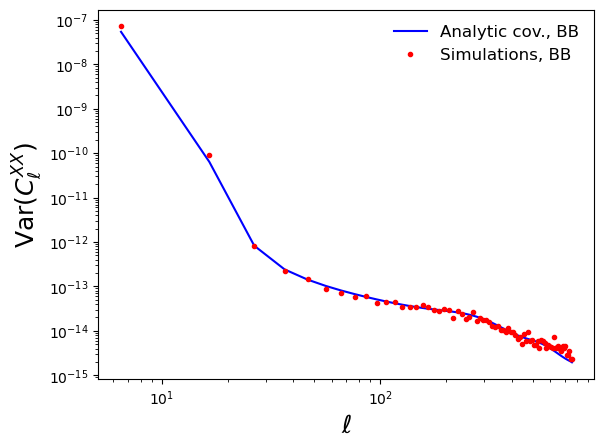

In [7]:
plt.figure()
leff = b.get_effective_ells()
plt.plot(leff, np.diag(cov_th), 'b-', label='Analytic cov., BB')
plt.plot(leff, np.std(cls[:, 3, :], axis=0)**2, 'r.', label='Simulations, BB')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$', fontsize=18)
plt.ylabel(r'${\rm Var}(C^{XX}_\ell)$', fontsize=18)
plt.legend(frameon=False, fontsize=12)